# ML Reglas de Precio

Objetivo: Identificar características importantes para asignación de reglas de precio e incremento de Ingresos (Estimated Revenue)

Variables disponibles cualitativas:  
    - Día (Day)CONFIGURABLE  
    - Día de la semana (Weekday)
    - Sitio (Site) CONFIGURABLE  
    - Tamaño de creativo (Creative Size) CONFIGURABLE  
    - Dispositivo (Device category) CONFIGURABLE  
    - País (Country) CONFIGURABLE  
    - Nombre Regla de Precio (pricing rule name)

Variables disponibles cuantitativas:  
    - Regla de Precio
    - Ad Requests.  
    - Matched Requests.  
    - Clicks.  
    - Estimated Revenue  
    - Ad Impressions  
    - Active View Enabled Impressions  
    - Active View measured Impressions  
    
$$eCPM = \frac{Ingresos}{Impresiones Vendidas} * 1000$$  
$$Fill Rate = \frac{Impresiones Vendidas}{Oportunidades}$$  
$$rCPM = \frac{Ingresos}{Oportunidades} * 1000 = eCPM * Fill Rate$$  
$$Viewability = \frac{Impresiones Vistas}{Impresiones Disponibles} * 1000$$

Actualmente tenemos los siguientes RMSE:  
RMSE con métricas VS RMSE sólo dimensiones  
LinearRegressor: 4.163198550626033 VS 4.228286483786043  
Árbol de Decisión con CV: 2.0217106846949955VS 4.315806210084512  
LinearRegressor con CV: 4.144651321967734 VS 4.194628244210746  
SVM: 4.541685841508111 VS 4.610738194900622  
Random Forest Grid : 2.94553254567179 {max_features': 8, 'n_estimators': 30} VS 3.5884419816764854 {'max_features': 6, 'n_estimators': 30}  
Random Forest RandomizedSearchCV: 2.9591995838687026 {'max_features': 7, 'n_estimators': 122} VS 3.5189419142933973 {'max_features': 7, 'n_estimators': 180}




In [480]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [481]:
# Carga de archivo base de datos con 9,994 registros, de los cuales información mensual desde Agosto 2020
import os
import tarfile
import urllib.request
import pandas as pd

PRULES_PATH = os.path.join("datasets")

def load_prules_data(prules_path=PRULES_PATH):
    csv_path = os.path.join(prules_path, "newbase_pricing_rules_open.csv")
    return pd.read_csv(csv_path)

# Carga y primera visualización de datos

In [727]:
# Visualización de la carga
target_site = 'DineroenImagen'
carga_prules = load_prules_data()
prules = carga_prules[carga_prules['site'] == target_site]

In [728]:
#prules = carga_prules
prules.head()

,day,weekday,site,creative_size,device,country,pricing_rules_name,pricing_rules,ad_requests,matched_ad_requests,clicks,revenue,ad_impressions,active_view_enabled_impressions,active_view_measured_impressions
110071,09/05/2022,lun,DineroenImagen,Sin Posicion,Desktop,Mexico,2 UPR Desktop NoUSA,0.85,4,1,0,0.00,0,0,0
110072,25/05/2022,mié,DineroenImagen,Sin Posicion,Desktop,Mexico,2 UPR Desktop NoUSA,0.50,4,2,0,0.02,1,1,1
110073,30/05/2022,lun,DineroenImagen,Sin Posicion,Desktop,Mexico,2 UPR Desktop NoUSA,0.50,2,1,0,0.00,1,1,1
110074,02/06/2022,jue,DineroenImagen,Sin Posicion,Desktop,Mexico,2 UPR Desktop NoUSA,0.50,11,9,0,0.00,1,1,1
110075,07/06/2022,mar,DineroenImagen,Sin Posicion,Desktop,Mexico,2 UPR Desktop NoUSA,0.50,16,2,0,0.00,0,0,0


In [729]:
# Información de tipo de datos por cada campo
prules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53808 entries, 110071 to 163878
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   day                               53808 non-null  object 
 1   weekday                           53808 non-null  object 
 2   site                              53808 non-null  object 
 3   creative_size                     53808 non-null  object 
 4   device                            53808 non-null  object 
 5   country                           53808 non-null  object 
 6   pricing_rules_name                53808 non-null  object 
 7   pricing_rules                     53808 non-null  float64
 8   ad_requests                       53808 non-null  int64  
 9   matched_ad_requests               53808 non-null  int64  
 10  clicks                            53808 non-null  int64  
 11  revenue                           53808 non-null  float64
 12

In [730]:
prules = prules.reset_index(drop = True)

In [698]:
prules.describe()

,pricing_rules,ad_requests,matched_ad_requests,clicks,revenue,ad_impressions,active_view_enabled_impressions,active_view_measured_impressions
count,53808.000000,53808.000000,53808.000000,53808.000000,53808.000000,53808.000000,53808.000000,53808.000000
mean,2.229937,4183.094986,1348.570045,6.337905,14.646625,989.897171,987.581326,985.227884
std,1.805361,16429.761322,8486.843635,63.373357,133.063180,7400.499835,7385.773413,7374.305223
min,0.000000,1.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000
25%,1.000000,18.000000,4.000000,0.000000,0.030000,3.000000,3.000000,3.000000
50%,1.800000,117.000000,29.000000,0.000000,0.240000,18.000000,18.000000,18.000000
75%,2.800000,1152.000000,259.000000,0.000000,1.700000,140.000000,140.000000,139.000000
max,9.230000,529974.000000,472575.000000,4386.000000,11517.870000,442207.000000,441593.000000,441031.000000


Saving figure attribute_histogram_plots


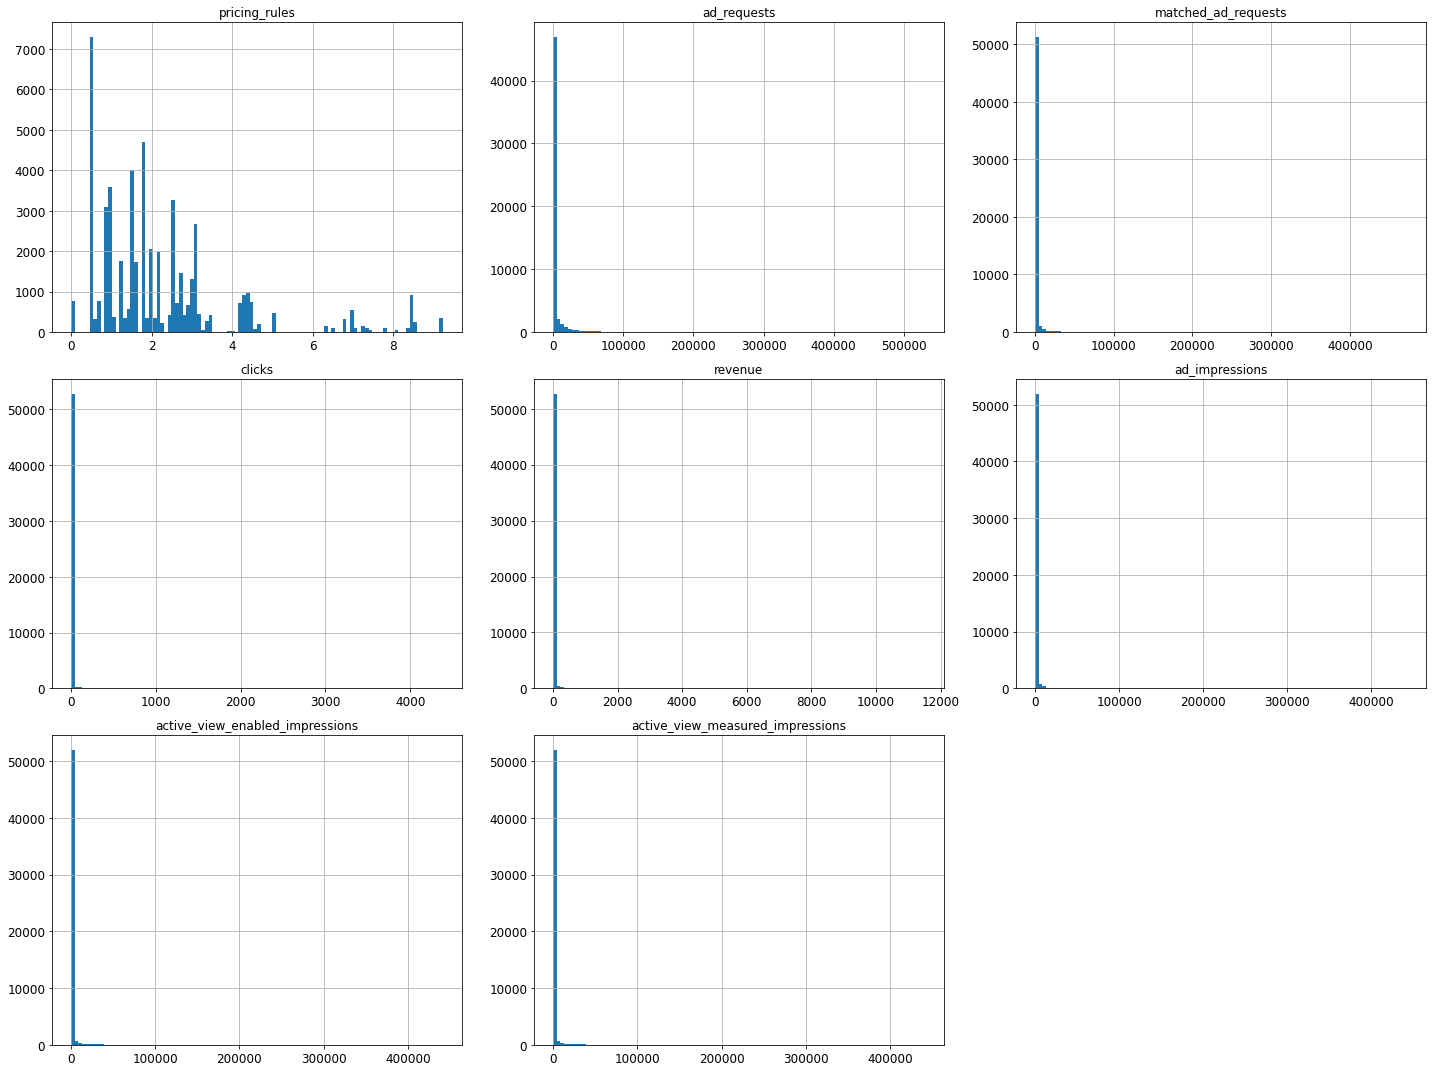

In [699]:
# Se observa que hay registros que tienen valores muy grandes.
%matplotlib inline
import matplotlib.pyplot as plt
prules.hist(bins=100, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# Generación de set de entramiento 80% y validación 20%

In [731]:
# Creación de Métrica rCPM Ingresos/Ad Requests * 1,000
prules['rCPM'] = prules['revenue']/prules['ad_requests']*1000

<AxesSubplot:>

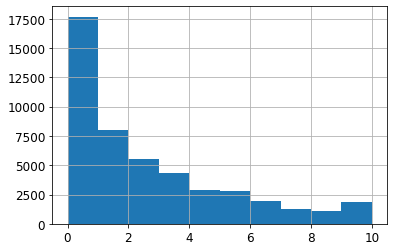

In [732]:
prules['rCPM'].hist(range = [0,10])

<AxesSubplot:>

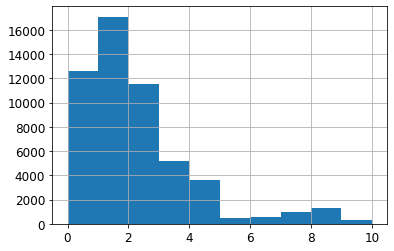

In [733]:
prules['pricing_rules'].hist(range = [0,10])

In [734]:
# Se hace la estratificación de las instancias por rCPM
prules['prules_cat'] = pd.cut(prules["pricing_rules"],
                               bins=[-np.inf, 0.8, 1.6, 2.4, 3.2,np.inf],
                               labels=[1, 2, 3, 4, 5])

In [735]:
# Estratificación con $1 de diferencia cada estrato
prules["prules_cat"].value_counts()

2    15504
4    11269
3     9731
1     9155
5     8149
Name: prules_cat, dtype: int64

<AxesSubplot:>

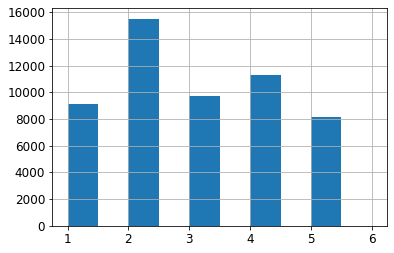

In [736]:
prules["prules_cat"].hist(range = [1,6])

In [737]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(prules, prules["prules_cat"]):
    strat_train_set = prules.loc[train_index]
    strat_test_set = prules.loc[test_index]

In [738]:
# Set estratificado
strat_test_set["prules_cat"].value_counts() / len(strat_test_set)

2    0.288143
4    0.209441
3    0.180821
1    0.170136
5    0.151459
Name: prules_cat, dtype: float64

In [739]:
prules["prules_cat"].value_counts() / len(prules)

2    0.288136
4    0.209430
3    0.180847
1    0.170142
5    0.151446
Name: prules_cat, dtype: float64

In [740]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("prules_cat", axis=1, inplace=True)

# Visualizar (dispersiones) y explorar (correlaciones, histogramas, etc.)

In [741]:
prules = strat_train_set.copy()

Saving figure better_visualization_plot


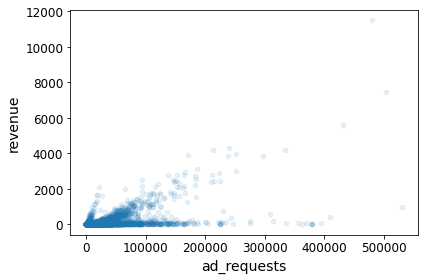

In [742]:
# Graficación de Ad Requests vs Estimated Revenue para ver correlaciones
prules.plot(kind="scatter", x="ad_requests", y="revenue", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure scatter_matrix_plot


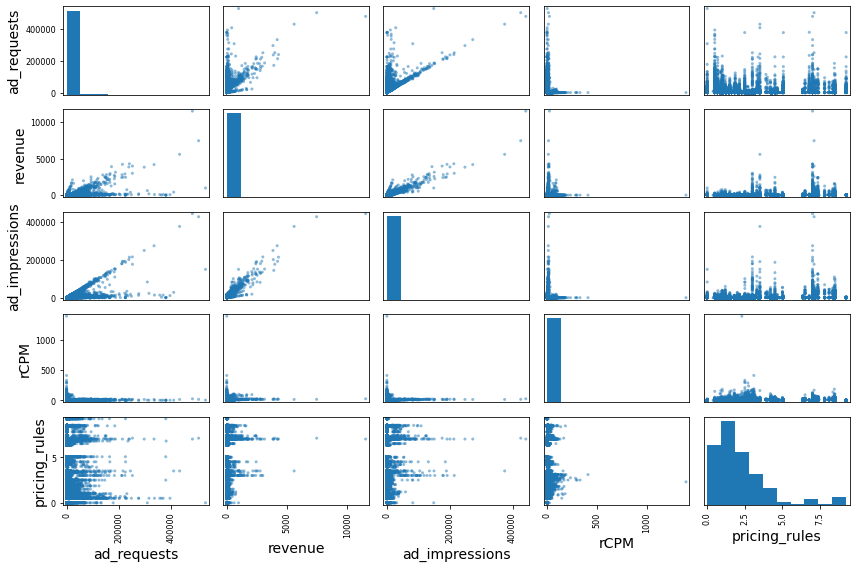

In [743]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
# Todas las gráficas se ven muy dispersas
from pandas.plotting import scatter_matrix

prules['rCPM'] = prules['revenue']/prules['ad_requests']*1000

attributes = ["ad_requests", "revenue", "ad_impressions",
              "rCPM", 'pricing_rules']
scatter_matrix(prules[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure pricing_rules_vs_estimated_revenue


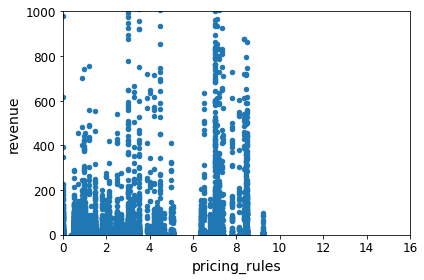

In [716]:
prules.plot(kind="scatter", x="pricing_rules", y="revenue")
plt.axis([0, 16, 0, 1000])
save_fig("pricing_rules_vs_estimated_revenue")

Saving figure pricing_rules_vs_rCPM


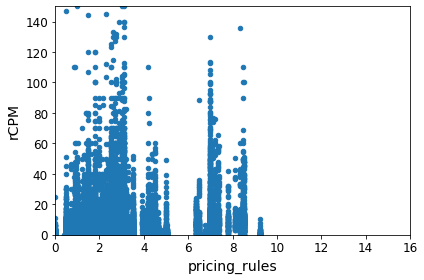

In [717]:
prules.plot(kind="scatter", x="pricing_rules", y="rCPM")
plt.axis([0, 16, 0, 150])
save_fig("pricing_rules_vs_rCPM")

In [744]:
# Se añaden otras métricas calculadas para analizar correlación.
prules['eCPM'] = prules['revenue']/prules['ad_impressions']*1000
prules['Fill Rate'] = prules['ad_impressions']/prules['ad_requests']

In [745]:
# La métrica con la que tiene más correlación es eCPM, el cual dependiente del rCPM.
# Otra métrica que es la que tiene mayor correlación es el Fill Rate.
corr_matrix = prules.corr()
corr_matrix["pricing_rules"].sort_values(ascending=False)

pricing_rules                       1.000000
Fill Rate                           0.189399
revenue                             0.168027
active_view_measured_impressions    0.159282
active_view_enabled_impressions     0.159221
ad_impressions                      0.159219
rCPM                                0.159147
clicks                              0.152138
eCPM                                0.142063
matched_ad_requests                 0.134966
ad_requests                         0.084273
Name: pricing_rules, dtype: float64

In [721]:
# Por el lado de los ingresos está relacionado con Impresiones
corr_matrix = prules.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue                             1.000000
active_view_measured_impressions    0.936689
active_view_enabled_impressions     0.936615
ad_impressions                      0.936501
clicks                              0.935942
matched_ad_requests                 0.906999
ad_requests                         0.565571
pricing_rules                       0.168027
Fill Rate                           0.110557
rCPM                                0.084396
eCPM                                0.034476
Name: revenue, dtype: float64

# Preparar (limpieza de datos, escalamiento)

In [746]:
# Creamos nuestro set de entrenamiento y nuestras etiquetas, a partir de nuestro set estratificado.
prules = strat_train_set.drop("pricing_rules", axis=1) # drop labels for training set
prules_labels = strat_train_set["pricing_rules"].copy()

In [723]:
prules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43046 entries, 40875 to 2523
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   day                               43046 non-null  object 
 1   weekday                           43046 non-null  object 
 2   site                              43046 non-null  object 
 3   creative_size                     43046 non-null  object 
 4   device                            43046 non-null  object 
 5   country                           43046 non-null  object 
 6   pricing_rules_name                43046 non-null  object 
 7   ad_requests                       43046 non-null  int64  
 8   matched_ad_requests               43046 non-null  int64  
 9   clicks                            43046 non-null  int64  
 10  revenue                           43046 non-null  float64
 11  ad_impressions                    43046 non-null  int64  
 12  a

In [747]:
# Ya que las métricas no son configurables para indluir en el comportamiento del CPM, se retiran.
prules = prules.drop('matched_ad_requests', axis=1)
prules = prules.drop('clicks', axis=1)
prules = prules.drop('ad_impressions', axis=1)
prules = prules.drop('revenue', axis=1)
prules = prules.drop('active_view_enabled_impressions', axis=1)
prules = prules.drop('active_view_measured_impressions', axis=1)
prules = prules.drop('rCPM', axis=1)

In [748]:
# Solamente nos quedan las características configurables
prules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43046 entries, 40875 to 2523
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   day                 43046 non-null  object
 1   weekday             43046 non-null  object
 2   site                43046 non-null  object
 3   creative_size       43046 non-null  object
 4   device              43046 non-null  object
 5   country             43046 non-null  object
 6   pricing_rules_name  43046 non-null  object
 7   ad_requests         43046 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 3.0+ MB


In [749]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [750]:
prules_num = prules.drop('day', axis=1)
prules_num = prules_num.drop('weekday', axis=1)
prules_num = prules_num.drop('site', axis=1)
prules_num = prules_num.drop('device', axis=1)
prules_num = prules_num.drop('country', axis=1)
prules_num = prules_num.drop('pricing_rules_name', axis=1)
prules_num = prules_num.drop('creative_size', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [751]:
imputer.fit(prules_num)

SimpleImputer(strategy='median')

In [752]:
imputer.statistics_

array([116.])

In [753]:
X = imputer.transform(prules_num)

In [754]:
prules_tr = pd.DataFrame(X, columns=prules_num.columns,
                          index=prules.index)
prules_tr.head()

,ad_requests
40875,63.0
8542,64729.0
17858,18203.0
18542,10288.0
20339,2575.0


In [755]:
prules.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43046 entries, 40875 to 2523
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   day                 43046 non-null  object
 1   weekday             43046 non-null  object
 2   site                43046 non-null  object
 3   creative_size       43046 non-null  object
 4   device              43046 non-null  object
 5   country             43046 non-null  object
 6   pricing_rules_name  43046 non-null  object
 7   ad_requests         43046 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 3.0+ MB


In [756]:
prules_cat = prules[['weekday']]
prules_cat['site'] = prules[['site']]
prules_cat['creative_size'] = prules[['creative_size']]
prules_cat['device'] = prules[['device']]
prules_cat['country'] = prules[['country']]
prules_cat.head(10)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_17656\840369367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prules_cat['site'] = prules[['site']]
C:\Users\Aaron\AppData\Local\Temp\ipykernel_17656\840369367.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prules_cat['creative_size'] = prules[['creative_size']]
C:\Users\Aaron\AppData\Local\Temp\ipykernel_17656\840369367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,weekday,site,creative_size,device,country
40875,lun,DineroenImagen,300x250,Desktop,Mexico
8542,dom,DineroenImagen,gen_amp,High-end mobile devices,Mexico
17858,mar,DineroenImagen,Tags,Desktop,Mexico
18542,jue,DineroenImagen,Sin Posicion,High-end mobile devices,Mexico
20339,jue,DineroenImagen,300x250,Desktop,Mexico
13117,sáb,DineroenImagen,300x250,Desktop,Mexico
52932,mar,DineroenImagen,728x90,Desktop,Mexico
17627,mar,DineroenImagen,Tags,Desktop,United States
49260,dom,DineroenImagen,Zocalo,High-end mobile devices,Mexico
31531,sáb,DineroenImagen,Sin Posicion,High-end mobile devices,Mexico


In [757]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [758]:
ordinal_encoder = OrdinalEncoder()
prules_cat_encoded = ordinal_encoder.fit_transform(prules_cat)
prules_cat_encoded[:10]

array([[2., 0., 1., 0., 0.],
       [0., 0., 8., 1., 0.],
       [3., 0., 6., 0., 0.],
       [1., 0., 5., 1., 0.],
       [1., 0., 1., 0., 0.],
       [5., 0., 1., 0., 0.],
       [3., 0., 4., 0., 0.],
       [3., 0., 6., 0., 1.],
       [0., 0., 7., 1., 0.],
       [5., 0., 5., 1., 0.]])

In [759]:
ordinal_encoder.categories_

[array(['dom', 'jue', 'lun', 'mar', 'mié', 'sáb', 'vie'], dtype=object),
 array(['DineroenImagen'], dtype=object),
 array(['1x1', '300x250', '300x600', '320x100', '728x90', 'Sin Posicion',
        'Tags', 'Zocalo', 'gen_amp'], dtype=object),
 array(['Desktop', 'High-end mobile devices'], dtype=object),
 array(['Mexico', 'United States'], dtype=object)]

In [760]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
prules_cat_1hot = cat_encoder.fit_transform(prules_cat)
prules_cat_1hot

<43046x21 sparse matrix of type '<class 'numpy.float64'>'
	with 215230 stored elements in Compressed Sparse Row format>

In [761]:
prules_cat_1hot.toarray()

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [762]:
cat_encoder = OneHotEncoder(sparse=False)
prules_cat_1hot = cat_encoder.fit_transform(prules_cat)
prules_cat_1hot

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [763]:
cat_encoder.categories_

[array(['dom', 'jue', 'lun', 'mar', 'mié', 'sáb', 'vie'], dtype=object),
 array(['DineroenImagen'], dtype=object),
 array(['1x1', '300x250', '300x600', '320x100', '728x90', 'Sin Posicion',
        'Tags', 'Zocalo', 'gen_amp'], dtype=object),
 array(['Desktop', 'High-end mobile devices'], dtype=object),
 array(['Mexico', 'United States'], dtype=object)]

In [764]:
prules.columns

Index(['day', 'weekday', 'site', 'creative_size', 'device', 'country',
       'pricing_rules_name', 'ad_requests'],
      dtype='object')

In [765]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
       ('imputer', SimpleImputer(strategy="median")),
       ('std_scaler', StandardScaler()),
   ])

prules_num_tr = num_pipeline.fit_transform(prules_num)

In [766]:
prules_num_tr

array([[-0.24802201],
       [ 3.64813179],
       [ 0.84492065],
       ...,
       [-0.24175597],
       [-0.25175754],
       [-0.21343827]])

In [767]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [768]:
num_attribs = list(prules_num)
cat_attribs = ['weekday', 'site', 'creative_size', 'device', 'country']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

prules_prepared = full_pipeline.fit_transform(prules)


In [769]:
type(prules_prepared)

scipy.sparse.csr.csr_matrix

In [770]:
prules_prepared.shape

(43046, 22)

In [771]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [772]:
num_attribs = list(prules_num)
cat_attribs = ['weekday', 'site', 'creative_size', 'device', 'country']

old_num_pipeline = Pipeline([
       ('selector', OldDataFrameSelector(num_attribs)),
       ('imputer', SimpleImputer(strategy="median")),
       ('std_scaler', StandardScaler()),
   ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [773]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
       ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [774]:
prules.head()

,day,weekday,site,creative_size,device,country,pricing_rules_name,ad_requests
40875,28/06/2021,lun,DineroenImagen,300x250,Desktop,Mexico,Dinero en Imagen,63
8542,01/08/2021,dom,DineroenImagen,gen_amp,High-end mobile devices,Mexico,Intowow_1622188298451_1,64729
17858,07/12/2021,mar,DineroenImagen,Tags,Desktop,Mexico,Dinero en Imagen,18203
18542,20/01/2022,jue,DineroenImagen,Sin Posicion,High-end mobile devices,Mexico,Default All Sites UPR,10288
20339,17/02/2022,jue,DineroenImagen,300x250,Desktop,Mexico,Dinero en Imagen,2575


In [775]:
old_prules_prepared = old_full_pipeline.fit_transform(prules)
old_prules_prepared

array([[-0.24802201,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 3.64813179,  1.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.84492065,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.24175597,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.25175754,  1.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-0.21343827,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ]])

In [776]:
old_prules_prepared

array([[-0.24802201,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 3.64813179,  1.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.84492065,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.24175597,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.25175754,  1.        ,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-0.21343827,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ]])

In [777]:
old_prules_prepared.shape

(43046, 22)

In [634]:
# Esto hace comparación de la manera manual y al llevarlo a un pipeline, el cual no nos deja comparar por formato de arreglos.
np.allclose(prules_prepared, old_prules_prepared)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# Select and train model

In [778]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(prules_prepared, prules_labels)

LinearRegression()

In [779]:
# let's try the full preprocessing pipeline on a few training instances
some_data = prules.iloc[:5]
some_labels = prules_labels.iloc[:5]
some_data_prepared = old_full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

#Predictions: [2.66796875 3.90234375 6.05273438 2.62695312 4.44921875]

Predictions: [1.87954996 4.88551653 1.74733418 1.27609983 1.87777428]


In [780]:
print("Labels:", list(some_labels))

Labels: [2.7, 0.0, 2.15, 1.0, 4.2]


In [781]:
from sklearn.metrics import mean_squared_error

prules_predictions = lin_reg.predict(prules_prepared)
lin_mse = mean_squared_error(prules_labels, prules_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# 4.164669841419033 con old_housing_prepared

1.3517876423824444

In [782]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(prules_labels, prules_predictions)
lin_mae

#2.2368766406313103

0.9221352975703092

In [783]:
## Arbol de decisiones
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(prules_prepared, prules_labels)

DecisionTreeRegressor(random_state=42)

In [784]:
prules_predictions = tree_reg.predict(prules_prepared)
tree_mse = mean_squared_error(prules_labels, prules_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# 2.1507443228766537e-18 con old_housing_prepared

0.6882906016744177

# Crossvalidation

In [785]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, prules_prepared, prules_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [786]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

# Scores: [2.53063224 1.65313644 1.92524027 1.77622569 1.67485054 3.42446451 1.26491669 2.39963266 3.30065268 2.33640075]
#Mean: 2.228615247535616
#Standard deviation: 0.6763606615134431

Scores: [1.71037872 1.80753529 1.74108378 1.66146225 1.72958049 1.74874572
 1.76930075 1.78614718 1.68814711 1.8090773 ]
Mean: 1.745145858507606
Standard deviation: 0.04687913693817042


In [789]:
lin_scores = cross_val_score(lin_reg, prules_prepared, prules_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
# Scores: [4.86020258 3.50517806 4.10335816 4.06575035 3.40217691 3.77936185 3.6603779  3.91574004 6.10113525 4.05323212]
# Mean: 4.144651321967734
# Standard deviation: 0.7574089219540697

Scores: [1.32953596 1.36467453 1.35953576 1.32155283 1.36217398 1.36384814
 1.31355073 1.37225485 1.34233862 1.394311  ]
Mean: 1.352377638993409
Standard deviation: 0.023798581759532592


In [788]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(prules_prepared, prules_labels)
prules_predictions = svm_reg.predict(prules_prepared)
svm_mse = mean_squared_error(prules_labels, prules_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

4.610738194900622

In [396]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [397]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [398]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [399]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4.433864344361121 {'max_features': 2, 'n_estimators': 3}
3.900383701779921 {'max_features': 2, 'n_estimators': 10}
3.767768535852919 {'max_features': 2, 'n_estimators': 30}
4.27491403610016 {'max_features': 4, 'n_estimators': 3}
3.857924077735108 {'max_features': 4, 'n_estimators': 10}
3.685504344553014 {'max_features': 4, 'n_estimators': 30}
4.087741145251072 {'max_features': 6, 'n_estimators': 3}
3.709990365731229 {'max_features': 6, 'n_estimators': 10}
3.5884419816764854 {'max_features': 6, 'n_estimators': 30}
4.4417264168722355 {'max_features': 8, 'n_estimators': 3}
3.76841009203452 {'max_features': 8, 'n_estimators': 10}
3.588450130218963 {'max_features': 8, 'n_estimators': 30}
4.519452858020348 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
3.9255945892782216 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
4.432765495667687 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
3.8638563630557634 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [400]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.081254,0.010356,0.000798,0.000978,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-20.794252,-17.941718,...,-19.659153,4.878129,16,-4.965007e+00,-5.133800e+00,-6.085451e+00,-5.764934e+00,-5.267909e+00,-5.443420e+00,4.174021e-01
1,0.280848,0.008190,0.003790,0.002034,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-15.311212,-14.617938,...,-15.212993,4.399096,10,-2.465269e+00,-2.654259e+00,-2.779991e+00,-2.868114e+00,-2.353860e+00,-2.624299e+00,1.913169e-01
2,0.805590,0.007268,0.015610,0.000018,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-14.376563,-12.426112,...,-14.196080,4.929418,6,-2.183978e+00,-2.188633e+00,-2.198333e+00,-2.375605e+00,-1.673028e+00,-2.123915e+00,2.366351e-01
3,0.084354,0.007656,0.000000,0.000000,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-21.758449,-16.976160,...,-18.274890,4.383783,14,-4.985384e+00,-6.095893e+00,-5.847541e+00,-5.717519e+00,-4.663830e+00,-5.462033e+00,5.440570e-01
4,0.273591,0.008279,0.007047,0.007152,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-16.619827,-13.799087,...,-14.883578,4.790821,8,-2.356043e+00,-2.430728e+00,-2.708629e+00,-2.628783e+00,-2.215422e+00,-2.467921e+00,1.797068e-01
5,0.827905,0.031313,0.012500,0.006250,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-14.622085,-12.698417,...,-13.582942,4.681464,3,-2.049610e+00,-2.024178e+00,-2.134868e+00,-2.111962e+00,-1.592888e+00,-1.982701e+00,1.990049e-01
6,0.096851,0.011688,0.003125,0.006249,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-19.366277,-16.265997,...,-16.709628,4.294091,12,-4.341497e+00,-4.425395e+00,-4.981083e+00,-4.392763e+00,-4.716759e+00,-4.571500e+00,2.429211e-01
7,0.290548,0.014253,0.003125,0.006250,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-15.359468,-11.758132,...,-13.764029,4.626621,4,-2.261110e+00,-2.282761e+00,-2.585678e+00,-2.281637e+00,-2.085661e+00,-2.299369e+00,1.610575e-01
8,0.835233,0.014600,0.012493,0.006247,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-13.522844,-11.229923,...,-12.876916,4.975776,1,-2.010944e+00,-2.057740e+00,-2.136919e+00,-2.030357e+00,-1.533723e+00,-1.953937e+00,2.144422e-01
9,0.093716,0.000035,0.000000,0.000000,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-25.555151,-15.287710,...,-19.728934,5.349866,17,-4.454174e+00,-4.749681e+00,-4.261238e+00,-5.825538e+00,-4.330017e+00,-4.724129e+00,5.755385e-01


In [401]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A5C55C8A60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A5D73253A0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [402]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3.5189419142933973 {'max_features': 7, 'n_estimators': 180}
3.753960982039677 {'max_features': 5, 'n_estimators': 15}
3.638079856583578 {'max_features': 3, 'n_estimators': 72}
3.7139360756376756 {'max_features': 5, 'n_estimators': 21}
3.5216554851532296 {'max_features': 7, 'n_estimators': 122}
3.6328372016886576 {'max_features': 3, 'n_estimators': 75}
3.63417027926586 {'max_features': 3, 'n_estimators': 88}
3.5684677711895563 {'max_features': 5, 'n_estimators': 100}
3.615831235513285 {'max_features': 3, 'n_estimators': 150}
4.514047623625084 {'max_features': 5, 'n_estimators': 2}


In [403]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.00789751, 0.00589601, 0.00857604, 0.00571572, 0.0050521 ,
       0.00557862, 0.00494119, 0.00738304, 0.02281952, 0.01132711,
       0.02626624, 0.00887418, 0.00823298, 0.00876928, 0.02104204,
       0.01409712, 0.00755523, 0.00981245, 0.00990463, 0.0098575 ,
       0.01308132, 0.00585989, 0.02788361, 0.01207511, 0.01371357,
       0.02122312, 0.01891848, 0.00711404, 0.00992204, 0.03632383,
       0.01286996, 0.00774965, 0.00988809, 0.00547753, 0.00157135,
       0.0170971 , 0.00986706, 0.00244527, 0.00805235, 0.00285159,
       0.00314288, 0.05300709, 0.00454786, 0.01514459, 0.05687594,
       0.01762843, 0.00082213, 0.00251404, 0.00247905, 0.01259953,
       0.01011428, 0.00168469, 0.00442186, 0.01028279, 0.02772831,
       0.00328577, 0.00206294, 0.00143628, 0.00290801, 0.06002329,
       0.00557329, 0.0423393 , 0.03384746, 0.03428353, 0.02582054,
       0.11184265])

In [412]:
#extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
#attributes = num_attribs + cat_one_hot_attribs
attributes = cat_one_hot_attribs
#attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.027883611556500272, '01/11/2021'),
 (0.026266239783451772, '01/06/2021'),
 (0.02281952385169872, '01/05/2021'),
 (0.02104204477500611, '01/08/2020'),
 (0.014097121597771673, '01/08/2021'),
 (0.013713570872409073, '01/12/2021'),
 (0.013081315818803192, '01/10/2021'),
 (0.01207510861312632, '01/12/2020'),
 (0.011327105657672249, '01/05/2022'),
 (0.009904625233976543, '01/09/2021'),
 (0.009857504910584106, '01/10/2020'),
 (0.009812448145176778, '01/09/2020'),
 (0.00887417576682825, '01/06/2022'),
 (0.008769281746419132, '01/07/2022'),
 (0.00857603709580473, '01/02/2021'),
 (0.008232978478201534, '01/07/2021'),
 (0.007897514374067733, '01/01/2021'),
 (0.007555231788847258, '01/08/2022'),
 (0.0073830389026125045, '01/04/2022'),
 (0.005896011129708379, '01/01/2022'),
 (0.005859887783075438, '01/11/2020'),
 (0.005715715733352334, '01/02/2022'),
 (0.005578615090693512, '01/03/2022'),
 (0.00505210414446329, '01/03/2021'),
 (0.004941193651227905, '01/04/2021')]

In [413]:
final_model = grid_search.best_estimator_

strat_test_set = strat_test_set[strat_test_set['Position Ad Unit'] != '180 » s180']
X_test = strat_test_set.drop("rCPM", axis=1)
y_test = strat_test_set["rCPM"].copy()

In [414]:
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

In [415]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [416]:
final_rmse

4.9041717173941155

In [417]:
from scipy import stats

In [418]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

C:\Users\Aaron\AppData\Local\Temp\ipykernel_17656\2583762534.py:6: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(stats.t.interval(confidence, m - 1,


array([      nan, 7.3161068])

In [419]:
stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors))

(-5.423618189059223, 53.52541865643592)

# Polinomial Regression

In [431]:
X = housing_prepared
y = housing_labels

In [428]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

<1x66 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [429]:
X_poly[0]

<1x2277 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [432]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(3.443614936697516,
 array([-0.59676448,  0.01480428, -0.30920945, ..., -0.43971829,
         0.        ,  1.09619754]))

In [434]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown